# importing & Set-up
#things to try 
- try different models (classifiers only)
- 

In [2]:
import pandas as pd                                  
import numpy as np                                     
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error         
from sklearn.preprocessing import LabelEncoder         
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold,StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
import sys, os, contextlib

@contextlib.contextmanager
def suppress_output(): 
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try: 
            yield
        finally: 
            sys.stdout = old_stdout
            sys.stderr = old_stderr

class CFG:
  data_folder ="../data/"

def reading_data(path: str) -> pd.DataFrame:
  sample = pd.read_csv(path + "SampleSubmission.csv")
  train = pd.read_csv(path + 'Train.csv')
  test = pd.read_csv(path + 'Test.csv')
  return sample,train,test

sample,train,test = reading_data(CFG.data_folder)
sample_id = sample['id']
test_id = test['id']
train_id = train['id']
n_splits = 5
gkf = StratifiedGroupKFold(n_splits=n_splits)
seed = 7 
tiney_fraction = 1e-05

#pd.options.display.max_columns = 200

misslead = [2, 12, 29, 31, 38, 77, 81, 97, 102, 115, 116, 130, 131, 133, 136, 143,
            146, 150, 153, 171, 180, 220, 221, 225, 231, 233, 244, 249, 270, 271, 274,
            283, 303, 343, 355, 396, 409, 417, 424, 435, 467, 470, 492, 495, 496, 515, 
            545, 551, 560, 579, 585, 586, 589, 592, 598, 611, 617, 636, 654, 656, 664, 683,
            688, 718, 721, 726, 754, 784, 788, 806, 812, 842, 855, 857, 862, 894, 900, 904,
            924, 947, 960, 980, 994, 1011, 1012, 1017, 1020, 1023, 1024, 1025, 1034, 1040, 
            1045, 1057, 1061, 1081, 1086, 1121, 1122, 1138, 1151, 1156, 1178, 1207, 1211, 1224, 
            1240, 1243, 1246, 1255, 1262, 1267, 1286, 1302, 1315, 1334, 1336, 1358, 1366, 1367,
            1392, 1405, 1427, 1461, 1465, 1474, 1504, 1513, 1517, 1521, 1522, 1530, 1534, 1585, 
            1587, 1604, 1608, 1614, 1615, 1619, 1625, 1646, 1649, 1652, 1656, 1657, 1665, 1674,
            1677, 1708, 1736, 1740, 1795, 1800, 1803, 1807, 1810, 1831, 1845, 1851, 1861, 1869,
            1876, 1877, 1886, 1893, 1898, 1900, 1930, 1953, 1954, 1967, 1994, 1999, 2020,2029,
            2034, 2050, 2055, 2056, 2065, 2066, 2086, 2095, 2105, 2120, 2122]

In [3]:
print(f"Before :{train.shape}")
train.fillna(method='ffill',inplace=True)
test.fillna(method='ffill',inplace=True)
#remove bad missleading classes points. 
"""classes = train['Target'].unique()
indices_to_remove = []
for idx in misslead:
    target_value = train.loc[idx, 'Target']
    other_samples = train[(train['Target'] == target_value) & (train.index != idx)]
    if len(other_samples) > 1:
        indices_to_remove.append(idx)
train = train.drop(indices_to_remove)
train_id = train['id']
print(train.shape)"""

Before :(2123, 43)


/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_11137/613267490.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill',inplace=True)
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_11137/613267490.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill',inplace=True)


"classes = train['Target'].unique()\nindices_to_remove = []\nfor idx in misslead:\n    target_value = train.loc[idx, 'Target']\n    other_samples = train[(train['Target'] == target_value) & (train.index != idx)]\n    if len(other_samples) > 1:\n        indices_to_remove.append(idx)\ntrain = train.drop(indices_to_remove)\ntrain_id = train['id']\nprint(train.shape)"

In [4]:
"""#setup clusters 
kmeans = KMeans(n_clusters=2)
#try different values 

lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 6
num_clusters_lon = 6
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = ((row['LAT2'] - lat_min) / lat_step)
    lon_cluster = ((row['LON1'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min)"""

In [5]:
"""geospatial_columns = ['LAT2', 'LON1', 'ELEV1', 'PEND1']
geo_train_data = train[geospatial_columns]
geo_test_data = test[geospatial_columns]
n_clusters = 10 #try different number here 
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
train['Spatial_Group'] = kmeans.fit_predict(geo_train_data)
test['Spatial_Group'] = kmeans.predict(geo_test_data)"""

In [6]:
for df in(train,test):
    df.drop(columns=['id'], axis=1,inplace=True)
    #df['lat_cluster'] = df['lat_cluster'].astype(int)
    #df['lon_cluster'] = df['lon_cluster'].astype(int)
    #df['cluster'] = df['lon_cluster'] + df['lat_cluster']

"""predictive_features = ['Spatial_Group','lon_cluster','lat_cluster','NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PRECIPAN1', 'TMPMAX1', 'TMPMIN1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1','Target']
for df in (train,test):
    for col in df.columns: 
        if col not in predictive_features:
            df.drop(columns=[col],inplace=True)
"""
#test_features = [feature for feature in predictive_features if feature != 'Target']
#train = train[predictive_features] 
#test = test[test_features]

"predictive_features = ['Spatial_Group','lon_cluster','lat_cluster','NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PRECIPAN1', 'TMPMAX1', 'TMPMIN1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1','Target']\nfor df in (train,test):\n    for col in df.columns: \n        if col not in predictive_features:\n            df.drop(columns=[col],inplace=True)\n"

# validation

In [7]:
model = CatBoostClassifier(random_state=seed)
skf = StratifiedKFold(n_splits=5)

def validate(trainset, testset, target_col, unique_classes):
    with suppress_output(): 
        model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    y_predicted = model.predict_proba(testset.drop(columns=[target_col]))  
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_predicted[valid_idx]
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    print(f"Log Loss: {score}")
    return score

unique_classes = np.sort(train['Target'].unique())  
scores = []

for train_index, test_index in skf.split(train.drop(columns='Target'), train['Target']): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    score = validate(trainset=train_v, testset=test_v, target_col='Target', unique_classes=unique_classes)
    scores.append(score)

print(f'Mean Log Loss: {np.mean(scores)}')
value  = np.array(scores).mean()

/Users/ahmed/Downloads/computerscience/AI-Compeitions/INEGI-GCIM/vegitiables/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Log Loss: 3.629659876861406
Log Loss: 3.7657811296958803
Log Loss: 3.7456290429915926
Log Loss: 3.661252495331095
Log Loss: 3.5584287095124822
Mean Log Loss: 3.6721502508784916


In [8]:
"""from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

model_weights = {'lgbm': 0.3, 'xgb': 0.5, 'knn': 0.2}  #try different number here 

lgbm_model = GradientBoostingClassifier()  
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
knn_model = KNeighborsClassifier()

def validate(trainset, testset, target_col, unique_classes):
    with suppress_output():
       
        lgbm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
        xgb_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
        knn_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    
    y_pred_lgbm = lgbm_model.predict_proba(testset.drop(columns=[target_col]))
    y_pred_xgb = xgb_model.predict_proba(testset.drop(columns=[target_col]))
    y_pred_knn = knn_model.predict_proba(testset.drop(columns=[target_col]))
    
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['xgb'] * y_pred_xgb +
                       model_weights['knn'] * y_pred_knn)
    
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_pred_weighted[valid_idx]
    
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    print(f"Log Loss: {score}")
    return score

le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])

unique_classes = np.sort(train['Target'].unique()) 

gkf = StratifiedKFold(n_splits=5)

scores = []
for train_index, test_index in gkf.split(train.drop(columns='Target'), train['Target']): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    score = validate(trainset=train_v, testset=test_v, target_col='Target', unique_classes=unique_classes)
    scores.append(score)
value  = np.array(scores).mean()
print(f'Mean Log Loss: {np.mean(scores)}')
"""

'from sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.metrics import log_loss\nfrom sklearn.model_selection import StratifiedGroupKFold\nfrom sklearn.preprocessing import LabelEncoder\nimport xgboost as xgb\n\nmodel_weights = {\'lgbm\': 0.3, \'xgb\': 0.5, \'knn\': 0.2}  #try different number here \n\nlgbm_model = GradientBoostingClassifier()  \nxgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric=\'mlogloss\')\nknn_model = KNeighborsClassifier()\n\ndef validate(trainset, testset, target_col, unique_classes):\n    with suppress_output():\n       \n        lgbm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])\n        xgb_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])\n        knn_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])\n    \n    y_pred_lgbm = lgbm_model.predict_proba(testset.drop(columns=[target_col]))\n    y_pred_xgb = xgb_model.predict_proba(testset.drop(columns=[target_col]))\n    y

In [9]:
value

3.6721502508784916

In [10]:
with suppress_output(): 
    model.fit(train.drop(columns='Target'), train['Target'])

# Get predicted probabilities
y_pred = model.predict_proba(test)

# Ensure that probabilities are never exactly 0 or 1 (for log loss stability)
# Clip probabilities to avoid zeros and ones
y_pred = np.clip(y_pred, 0.001, 0.999)

# Create a DataFrame for the submission
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]
sub_df = pd.DataFrame(y_pred, columns=class_labels)

# Add the 'id' column
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Handle missing columns (if any class labels are missing)
all_target_labels = [f"Target_{i}" for i in range(125)] 
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0.001  # Set a small value instead of zero

# Save submission file
sub_df.to_csv(f"../submissions/submission{value}.csv", index=False)
#cliped probability.

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_11137/2290666813.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0.001  # Set a small value instead of zero
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_11137/2290666813.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0.001  # Set a small value instead of zero
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_11137/2290666813.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [ ]:
with suppress_output(): 
    model.fit(train.drop(columns='Target'),train['Target'])
y_pred = model.predict_proba(test)
y_pred = np.round(y_pred,2)
mask = y_pred >= 0.9 #threshold
y_pred[~mask] = 0
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

all_target_labels = [f"Target_{i}" for i in range(125)] 
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  
sub_df.to_csv(f"../submissions/submission{value}.csv", index=False)

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_66516/467898307.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_66516/467898307.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_66516/467898307.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [ ]:
for col in sub_df.columns:
    if (pd.to_numeric(sub_df[col], errors='coerce') > 0.0).any():
        print('hell yeah, finally no zeros outputs')
    else: 
        print('not your lucky day')
        break

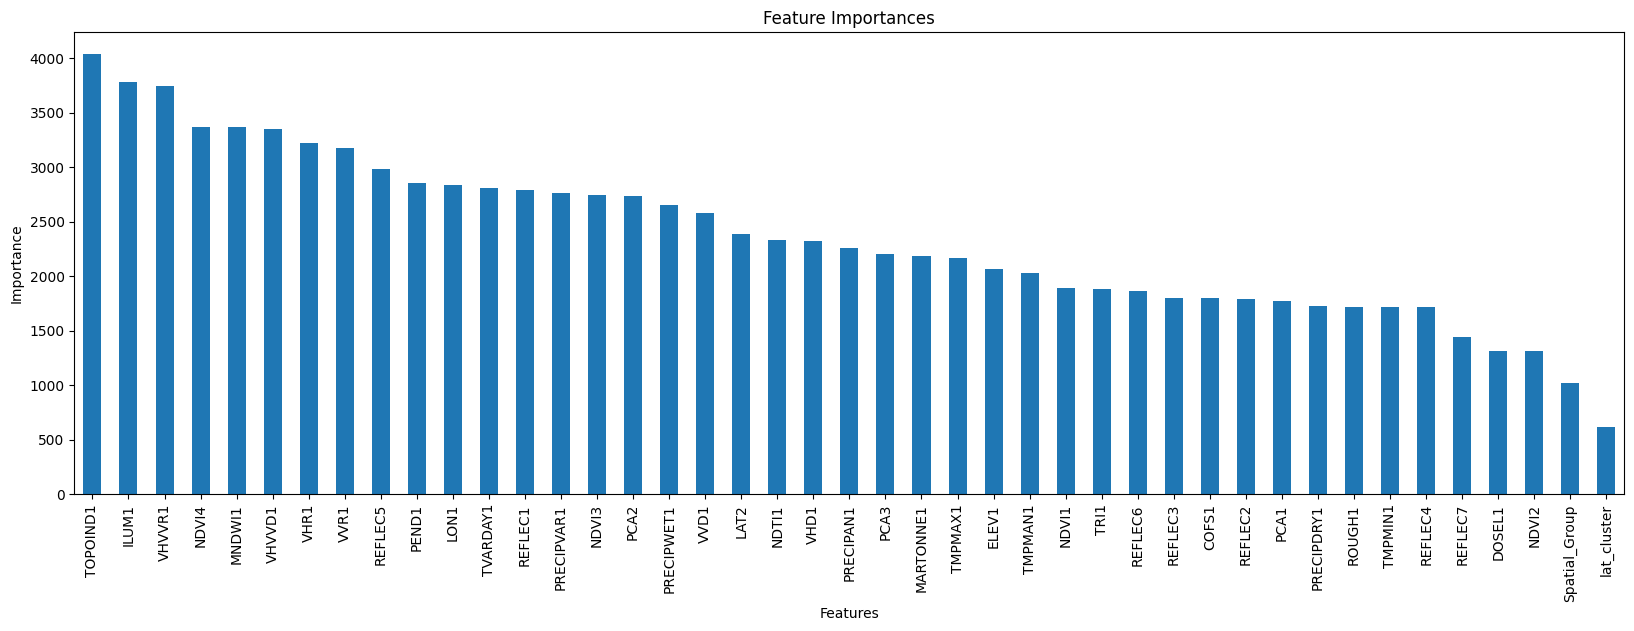

In [ ]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(20, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [12]:
train.columns

Index(['REFLEC1', 'REFLEC2', 'REFLEC3', 'REFLEC4', 'REFLEC5', 'REFLEC6',
       'REFLEC7', 'PCA1', 'PCA2', 'PCA3', 'NDVI1', 'NDVI2', 'NDVI3', 'NDVI4',
       'ELEV1', 'PEND1', 'ILUM1', 'TOPOIND1', 'ROUGH1', 'TRI1', 'COFS1',
       'TMPMAN1', 'TMPMAX1', 'TMPMIN1', 'TVARDAY1', 'PRECIPAN1', 'PRECIPWET1',
       'PRECIPDRY1', 'PRECIPVAR1', 'MARTONNE1', 'LAT2', 'LON1', 'DOSEL1',
       'VVR1', 'VHR1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1',
       'Target', 'lat_cluster', 'Spatial_Group'],
      dtype='object')

In [ ]:
# try training the PCA features alone or without it. 
